# Jupyter Notebook for locating a seismic event using McMC sampling

### TASK:

Locate a seismic event within an homogeneous half-space, using P- arrival times. Hypocentral parameters will be found using a "Markov chain Monte Carlo" methodology, and including a full Error Covariance matrix (necessary for DAS data)

### WORKFLOW:

(1) Define data and model space (i.e. prior information about hypocenter parameters)

(2) Define the Error Covariance matrix

(3) Start the McMC sampling form a random point in the model space

(4) Compute Likelihood of the starting model

#### Iterate fo N steps in the Markov chain:

(3) Modify the _current model_ (the starting model in the first iteration) proposing a _candidate model_ from the prior information

(4) Compute the Likelihood of the candidate model

(5) Accept or Reject candidate model using Metropolis rule

(5.1) If Accepted, the candidate model becomes the current model
(5.2) Id Rejected, the current model is kept and the candidate is removed from the chain

(6) Every 100 steps in the chain: store the current model

(7) Back to (3)

#### Post Processing:

(8) Extract relevant estimators of the hypocentral parameters from the stored models (eg mean and standard deviation) 



### Import libraries

In [11]:
import os

import numpy as np
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

import obspy
from obspy import UTCDateTime

from IPython.display import Image
import matplotlib.image as image 

#For the McMC sampling
from mcmc_locate_exp_cov import npa_candidate_model
from mcmc_locate_exp_cov import npa_log_likelihood
from mcmc_locate_exp_cov import npa_LOCATE_syn
from mcmc_locate_exp_cov import npa_metropolis
from mcmc_locate_exp_cov import npa_get_starting_model


### Definizioni

In [ ]:
#
###########################################################################################
#
# EDIT HERE ---- Baribles used in the Jnotebook for the analysis
#
#
#Seismic source
EVENT_NAME="DAS_1_SHOT_3"                        # LABEL for creating files
event_X=508466.9                                    # Approx X coord of the source
event_Y=4546244.2                             # Approx Y coord of the source
datafile="data/picks/shot_3.csv"             # P-wave arrival time at DAS channels 
cablegeom="input/DAS_INGV_04_cable_1_geom.dat"   # Coordinates of the sensing FO channels
degree_or_meter="meters"
                    # Select measure unit for distance in X-Y
#
############################################################################################
#
# Derived variables -- 
#  
#   if "degree" is set, we expect regional source
#   if "meters" is set, we expect local source
#
#   McMC parameter space is set according to.
#
if degree_or_meter == "degree":
    dx=1
    dy=1
    zmax_mcmc=20000
    tmin_mcmc=-15
    tmax_mcmc=1
    vpmin_mcmc=5000.
    vpmax_mcmc=7000.
    std0=0.1
    x_lab="Longitude (degree)"
    y_lab="Latitude (degree)"
    conv=111194.                  # Approx Degree to meters conversion
else:
    dx=100
    dy=100
    zmax_mcmc=10
    tmin_mcmc=-0.5
    tmax_mcmc=0.5
    vpmin_mcmc=500.
    vpmax_mcmc=3000.
    std0=0.01
    x_lab="X-UTM (meters)"
    y_lab="Y-UTM (meters)"
    conv=1.
#
# 2D area where the seismic source will be located 
xmin_mcmc=event_X-dx
xmax_mcmc=event_X+dx
ymin_mcmc=event_Y-dy
ymax_mcmc=event_Y+dy
#
# Zoom close to the true location of the seismic source
xmin_zoom=event_X-dx/2
xmax_zoom=event_X+dx/2
ymin_zoom=event_Y-dy/2
ymax_zoom=event_Y+dy/2
#
#
print(' Selected event: ' + EVENT_NAME)
print(' Selected FO cable: ' + cablegeom)
print(' Selected data: ' + datafile)

 Selected event: DAS_1_SHOT_3
 Selected FO cable: input/DAS_INGV_04_cable_1_geom.dat
 Selected data: data/picks/shot_3.csv


### Map of selected FO cable and approx shot location

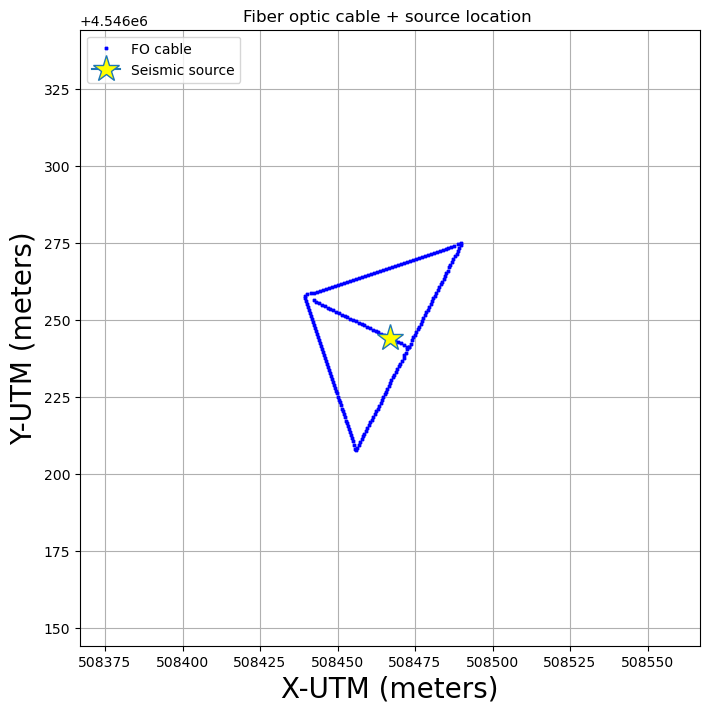

In [17]:

ch_pos, x_das, y_das = np.loadtxt(cablegeom, dtype=(float), usecols=(0,1,2), unpack=True)

nch_pos=len(x_das)


# Plot FO cable trace


plt.figure(figsize=(8,8))
plt.xlim(xmin_mcmc,xmax_mcmc)
plt.ylim(ymin_mcmc,ymax_mcmc)
plt.grid()
plt.plot(x_das, y_das,'X', markersize=2,c='blue',label='FO cable')
plt.plot(event_X, event_Y,marker='*', markersize=20, markerfacecolor='yellow',label='Seismic source')
plt.xlabel(x_lab, fontsize=20)
plt.ylabel(y_lab,fontsize=20)
plt.legend(loc='upper left')
plt.title('Fiber optic cable + source location ')
plt.show()



### Read data related to selected Shot (i.e. arrival times of P- wave at DAS channels)

In [18]:
# 1. Only channels with P-wave arrivl time are collected
# 2. I add the channel location to the array
# 3. I convert UTC time in Epoch Time

Ppick_orig = np.loadtxt(datafile, delimiter=',', dtype='str', usecols=(1), skiprows=1, unpack=True)
ch_orig = np.loadtxt(datafile, delimiter=',', dtype='int', usecols=(3), skiprows=1, unpack=True)
ph_orig = np.loadtxt(datafile, delimiter=',', dtype='str', usecols=(2), skiprows=1, unpack=True)

nch=len(Ppick_orig)

ch_sele = []
Ppick_sele = []
chlo = []
chla = []

ich=0
while ich<nch:
    pick0=Ppick_orig[ich]
    ph0=ph_orig[ich]
    ch0=ch_orig[ich]
    if pick0 != '' and ph0 == 'P':
        Ppick_date=pick0.split()[0]
        Ppick_time=pick0.split()[1]
        utc0= Ppick_date + "T" + Ppick_time
        Ppick_epoch=UTCDateTime(utc0)
        Ppick_sele.append(Ppick_epoch)
        ch_sele.append(ch0)
        # Select coordinates
        ich_all=0
        while ich_all < nch_pos:
            ch_pos0=ch_pos[ich_all]
            if ch_pos0 == ch0:
                chlo0=x_das[ich_all]
                chla0=y_das[ich_all]
                chlo.append(chlo0)
                chla.append(chla0)
            ich_all+=1        
    ich +=1
    
nch_sele=len(ch_sele)
Ppick_sele=np.array(Ppick_sele)
min_P_pick = min(Ppick_sele)
print('Found', nch_sele, 'stations with associated picking -- earliest P-arrival:', min_P_pick)

Found 207 stations with associated picking -- earliest P-arrival: 2025-06-23T09:43:44.661157Z


### Map of the selected DAS channels

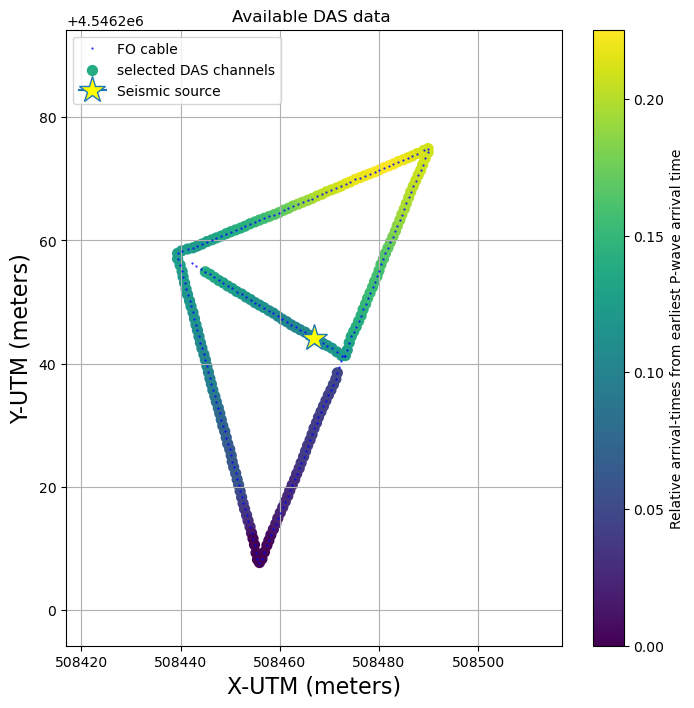

In [27]:

# Relative DAS data

Ppick = Ppick_sele - min_P_pick


plt.figure(figsize=(8,8))
plt.xlim(xmin_zoom,xmax_zoom)
plt.ylim(ymin_zoom,ymax_zoom)
plt.grid()
plt.plot(x_das, y_das, '.', markersize=1, c='blue',label='FO cable')
plt.scatter(chlo, chla, s=50, c=Ppick, cmap='viridis', label='selected DAS channels')
plt.colorbar(label='Relative arrival-times from earliest P-wave arrival time')
plt.plot(event_X, event_Y,marker='*', markersize=20, markerfacecolor='yellow',label='Seismic source')
plt.xlabel(x_lab, fontsize=16)
plt.ylabel(y_lab,fontsize=16)
plt.legend(loc='upper left')
plt.title('Available DAS data ')
# plt.show()
plt.savefig("./output/distance_cmap.png", dpi=600)


## Locate the seismic source using a Markov chain Monte Carlo approach

In [20]:
#######################################################
#######################################################
#
# EDIT HERE
#
# Define the model space
# (Uniform prior probability distirbution)
#
xmin=xmin_mcmc  # in m
xmax=xmax_mcmc  # in m
ymin=ymin_mcmc  # in m
ymax=ymax_mcmc  # in m
zmin=0.         # in m
zmax=zmax_mcmc  # in m
tmin=tmin_mcmc  # in s
tmax=tmax_mcmc  # in s
vpmin=vpmin_mcmc  # in m/s
vpmax=vpmax_mcmc  # in m/s

# FOR CREATING SYNTHETICS
#xmin=15.9       # in m
#xmax=17.9       # in m
#ymin=40.7       # in m
#ymax=40.7       # in m
#zmin=0          # in m
#zmax=0          # in m
#tmin=-3.        # in s
#tmax=-3.        # in s
#vpmin=6000.0    # in m/s
#vpmax=6000.0    # in m/s
#

#
#
#   MARKOV CHAIN MONTE CARLO PARAMETERS
# 
N_CHAINS=10                        # Number of chains
N_MOD_MCMC=2000                    # Number of samples collected alon the McMC
BURN_IN=1000                       # Samples discarded at the beginning of the McMC
PRIOR = 0                          # PRIOR SAMPLING: 1- sampling prior information; 0- Monte Carlo sampling 
#
#
#   EXPONENTIAL COVARIANCE MATRIX DEFINITIONS
#
r_corr=0.9
#
#
# RANDOM SEED -- to produce always the same sequence of pseudo-random numbers
#
rseed=210728
rng = np.random.default_rng(rseed)
#
#######################################################
#######################################################
#######################################################


#######################################################
#######################################################
#######################################################

#
# Pre-compute inverse of EXP cov matrix
#

cor = np.zeros((nch_sele,nch_sele), dtype=float)
icov = np.zeros((nch_sele,nch_sele), dtype=float)

ir=0
while ir < nch_sele:
    
    if ir == 0:
        diag0=1.0+(r_corr**2)
    if ir == 1:
        diag0=-1.0*r_corr
    if ir > 1:
        diag0=0.0

    ic=ir
    while ic < nch_sele:
    
        cor[ic-ir,ic]=diag0
        cor[ic,ic-ir]=diag0
    
        ic+=1
        
    ir+=1


cor[0,0]=1.0
cor[nch_sele-1,nch_sele-1]=1.0

ir=0
ic=0
while ir < nch_sele:
    ic=0
    while ic < nch_sele:
        icov[ir,ic]=(1.0/(1.0-(r_corr**2)))*(1.0/(std0*std0))*cor[ir,ic]
        ic += 1
    ir += 1
    
print('\n PRE-PROCESSING of the INVERSE COV MATRIX: \n')
print(cor,icov)
print('\n INVERSE of an EXPONENTIAL COV MATRIX should be tri-diagonal \n')

#######################################################
#######################################################
#######################################################


#
# Initialize vectors for collecting sampled models
#
ALL_X = []
ALL_Y = []
ALL_Z = []
ALL_T = []
ALL_VP = []

#
#
# (1) Campionamento dello spazio dei parametri (ripetuto N volte per M catene di Markov diverse)
#
ichain = 1 
while ichain <= N_CHAINS:
    
    #
    # (2) DEFINE STARTING MODEL as a random point in the model-space
    #
    X0, Y0, Z0, T0, VP0 = npa_get_starting_model(rng, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax, vpmin, vpmax)
    #
    print('\n%s\n%s%8.2f%s%8.2f%s%8.2f%s%8.2f%s%8.2f\n' % ("STARTING MODEL:",  " - X: ", X0, " - Y: ", Y0, " - Z: ", Z0, " - T0: ", T0, " - Vp: ", VP0)) 
    #
    # (3.1) COMPUTE SYNTHETICS for starting model
    #
    SYN_data_P = []
    SYN_data_P = npa_LOCATE_syn(nch_sele, chlo, chla, conv, X0, Y0, Z0, T0, VP0)
    #
    #
    # Write out synthetics -- for a synthetic test
    #
    if N_MOD_MCMC == 0 and ichain == 1:
        istat=0
        while istat < nch_sele:
            x1=chlo[istat]
            y1=chla[istat]
            ch0=ch_sele[istat]
            theo_P=SYN_data_P[istat]   # SYNTHETICS without noise
            theo_P=SYN_data_P[istat]+rng.normal(0.0,std0)  # SYNTHETICS with ADDED noise
            theo_P=min_P_pick+theo_P
            print("%d%s%s%s%d" % (istat,",",theo_P,",P,",ch0))
            istat += 1
    
    #
    #
    # (3.2) COMPUTE FIT TO STARTING MODEL
    #
    lppd0 = npa_log_likelihood(nch_sele, SYN_data_P, Ppick, icov)
    #
    #
    print('\n LOG LIKELIHOOD starting model: ', lppd0)
    #
    #
    #
    #
    #
    #
    #    START MCMC
    #
    #

    imod = 1
    while imod <= N_MOD_MCMC:
    #
    #


    #
    #
    #
    # (4.1) Propose a candidate model as a small preturbation of the current model
    #
    #
        X_cand, Y_cand, Z_cand, T_cand, VP_cand = npa_candidate_model(rng, X0, Y0, Z0, T0, VP0, xmin, xmax, ymin, ymax, zmin, zmax, tmin, tmax, vpmin, vpmax)
    #
    #

        #print("%s%10.3f%10.3f%10.3f" % ('\n   CURRENT MODEL: ', X0, Y0, Z0))
        #print("%s%10.3f%10.3f%10.3f" % (' CANDIDATE MODEL: ', X_cand, Y_cand, Z_cand))

    #
    #
    #  (4.2) Compute predicted data given by the candidate model
    #
    #
        SYN_data_P = []
        SYN_data_P = npa_LOCATE_syn(nch_sele, chlo, chla, conv, X_cand, Y_cand, Z_cand, T_cand, VP_cand)
    #
    #
    #
    # (4.3) Compute the Likelihood between observed data and predicted data
    #
    #
        lppd = npa_log_likelihood(nch_sele, SYN_data_P, Ppick,  icov)

        if PRIOR == 1:
            lppd0 = 1.0
            lppd  = 1.0
   
    #
    #
    # (4.4) Apply Metropolis'rule to select between candidate and current model
    #
    #
        Accepted = npa_metropolis(rng, lppd,lppd0)
    #
    #
        if imod % 100 == 0:
            print("%s%4d%s%9d%s%4d%s%16.2f%16.2f" % ('CHAIN: ', ichain, ' SAMPLED MODEL: ', imod, '  Accepted:', Accepted, '  LPPD: ', lppd, lppd0))



    #
    #
    # (4.5) Store the selected model for post-processing
    #
    #
    # If the candidate model is rejected, current model becomes candidate model
    #
        if Accepted == 0:
            
            X_cand = X0
            Y_cand = Y0
            Z_cand = Z0
            T_cand = T0
            VP_cand = VP0
            lppd = lppd0

    #
    # Store candidate model (after BURN-IN phase)
    #

        if imod >= BURN_IN:
            
            if imod % 100 == 0:
            
                ALL_X.append(X_cand)
                ALL_Y.append(Y_cand)
                ALL_Z.append(Z_cand)
                ALL_VP.append(VP_cand)
                ALL_T.append(T_cand)

    #
    # Candidate model becomes current model
    #

        X0 = X_cand
        Y0 = Y_cand
        Z0 = Z_cand
        T0 = T_cand
        VP0 = VP_cand
        lppd0 = lppd


    # Move McMC chain
        imod += 1
    
    
    
    

# Run a new indipendent McMC sampling
    ichain += 1



 PRE-PROCESSING of the INVERSE COV MATRIX: 

[[ 1.   -0.9   0.   ...  0.    0.    0.  ]
 [-0.9   1.81 -0.9  ...  0.    0.    0.  ]
 [ 0.   -0.9   1.81 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.81 -0.9   0.  ]
 [ 0.    0.    0.   ... -0.9   1.81 -0.9 ]
 [ 0.    0.    0.   ...  0.   -0.9   1.  ]] [[ 52631.57894737 -47368.42105263      0.         ...      0.
       0.              0.        ]
 [-47368.42105263  95263.15789474 -47368.42105263 ...      0.
       0.              0.        ]
 [     0.         -47368.42105263  95263.15789474 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ...  95263.15789474
  -47368.42105263      0.        ]
 [     0.              0.              0.         ... -47368.42105263
   95263.15789474 -47368.42105263]
 [     0.              0.              0.         ...      0.
  -47368.42105263  52631.57894737]]

 INVERSE of an EXPONENTIAL COV MATRIX should be tri-diagonal 


STARTING MODEL:
 - X:

## Post-processing: compute posterior mean values of the investigated parameters 

In [21]:
AVER_X = np.mean(ALL_X,axis=0)
STD_X = np.std(ALL_X,axis=0)

AVER_Y = np.mean(ALL_Y,axis=0)
STD_Y = np.std(ALL_Y,axis=0)

AVER_Z = np.mean(ALL_Z,axis=0)
STD_Z = np.std(ALL_Z,axis=0)

AVER_T = np.mean(ALL_T,axis=0)
STD_T = np.std(ALL_T,axis=0)

AVER_VP = np.mean(ALL_VP,axis=0)
STD_VP = np.std(ALL_VP,axis=0)


print('\n MEAN PPD  and STD PPD: \n')
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('X: ', AVER_X, STD_X, ' PRIOR MEAN/STD: ', 0.5*(xmin+xmax), (xmax-xmin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Y: ', AVER_Y, STD_Y, ' PRIOR MEAN/STD: ', 0.5*(ymin+ymax), (ymax-ymin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Z: ', AVER_Z, STD_Z, ' PRIOR MEAN/STD: ', 0.5*(zmin+zmax), (zmax-zmin)/sqrt(12)) )
print('%20s%10.4f%10.4f%25s%10.4f%10.4f' % ('T: ', AVER_T, STD_T, ' PRIOR MEAN/STD: ', 0.5*(tmin+tmax), (tmax-tmin)/sqrt(12)) )
print('%20s%10.2f%10.4f%25s%10.2f%10.4f' % ('Vp: ', AVER_VP, STD_VP, ' PRIOR MEAN/STD: ', 0.5*(vpmin+vpmax), (vpmax-vpmin)/sqrt(12)) )




 MEAN PPD  and STD PPD: 

                 X:  508452.69    3.5645         PRIOR MEAN/STD:  508466.90   57.7350
                 Y: 4546198.35    4.8530         PRIOR MEAN/STD: 4546244.20   57.7350
                 Z:       3.80    2.2900         PRIOR MEAN/STD:       5.00    2.8868
                 T:     0.0161    0.0095         PRIOR MEAN/STD:     0.0000    0.2887
                Vp:     506.13    5.2025         PRIOR MEAN/STD:    1750.00  721.6878


## Post-processing: 1D PPD  of the investigated parameters 

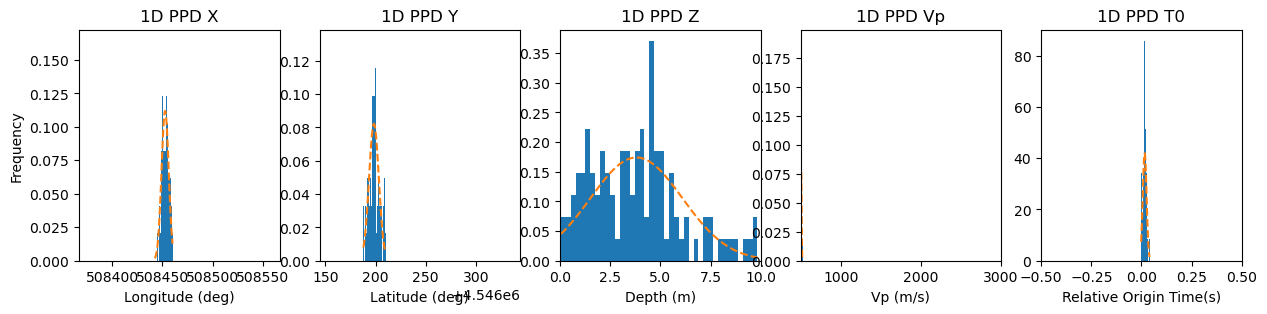

In [22]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.title.set_text('1D PPD X' )
mu = AVER_X
sigma = STD_X
n, bins, patches = ax1.hist(ALL_X, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax1.plot(bins,y,'--')
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel('Longitude (deg)')
ax1.set_ylabel('Frequency')

ax2.title.set_text('1D PPD Y' )
mu = AVER_Y
sigma = STD_Y
n, bins, patches = ax2.hist(ALL_Y, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax2.plot(bins,y,'--')
ax2.set_xlim(ymin, ymax)
ax2.set_xlabel('Latitude (deg)')

ax3.title.set_text('1D PPD Z' )
mu = AVER_Z
sigma = STD_Z
n, bins, patches = ax3.hist(ALL_Z, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax3.plot(bins,y,'--')
ax3.set_xlim(zmin,zmax)
ax3.set_xlabel('Depth (m)')

ax4.title.set_text('1D PPD Vp' )
mu = AVER_VP
sigma = STD_VP
n, bins, patches = ax4.hist(ALL_VP, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax4.plot(bins,y,'--')
ax4.set_xlim(vpmin,vpmax)
ax4.set_xlabel('Vp (m/s)')

ax5.title.set_text('1D PPD T0' )
mu = AVER_T
sigma = STD_T
n, bins, patches = ax5.hist(ALL_T, 40, density=True)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax5.plot(bins,y,'--')
ax5.set_xlim(tmin,tmax)
ax5.set_xlabel('Relative Origin Time(s)')


plt.show()


## Post-processing: 2D PPD  of the investigated parameters 

C:\Users\kshit\AppData\Local\Temp\ipykernel_24276\3422991917.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


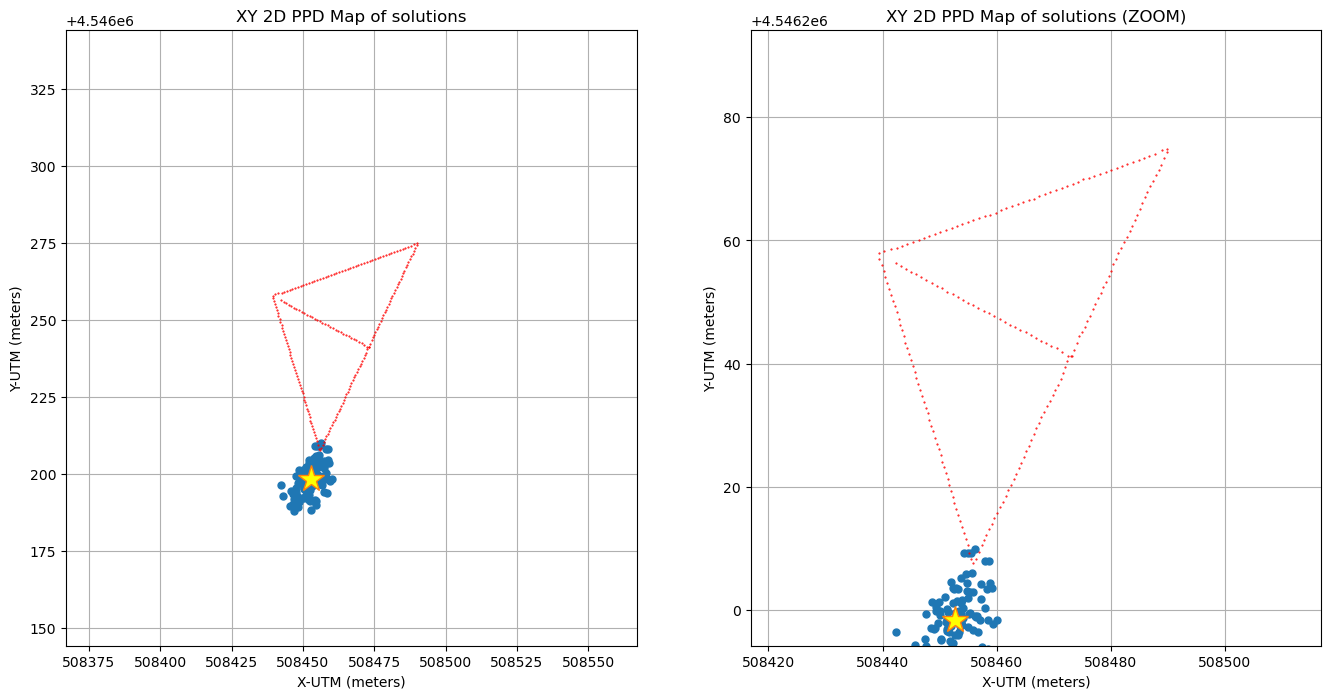

In [31]:

  
fig = plt.figure(figsize=(16.2,8))
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.2, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('XY 2D PPD Map of solutions' )
ax1.plot(ALL_X, ALL_Y, '.', markersize=10)
ax1.set_xlim(xmin_mcmc,xmax_mcmc)
ax1.set_ylim(ymin_mcmc,ymax_mcmc)
ax1.grid()
ax1.plot(AVER_X, AVER_Y,marker='*', markersize=20, markerfacecolor='yellow')
ax1.plot(x_das, y_das, '.', markersize=1, c='red')
ax1.set_ylabel(y_lab)
ax1.set_xlabel(x_lab)


ax2 = fig.add_subplot(gs[0, 1])
ax2.title.set_text('XY 2D PPD Map of solutions (ZOOM)' )
ax2.plot(ALL_X, ALL_Y, '.', markersize=10)
ax2.set_xlim(xmin_zoom,xmax_zoom)
ax2.set_ylim(ymin_zoom,ymax_zoom)
ax2.grid()
ax2.plot(AVER_X, AVER_Y,marker='*', markersize=20, markerfacecolor='yellow')
ax2.plot(x_das, y_das, '.', markersize=1, c='red')
ax2.set_ylabel(y_lab)
ax2.set_xlabel(x_lab)


outputFigure="MCMC_results.png"
plt.tight_layout()
plt.savefig(outputFigure, dpi=600)
plt.show()
